In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("SedonaSample") \
    .getOrCreate()

sc = spark.sparkContext

In [7]:
from py4j.java_gateway import java_import
java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")

In [8]:
from sedona.spark import *
config = SedonaContext.builder() \
    .config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-3.5_2.12:1.6.0,'
           'org.datasyslab:geotools-wrapper:1.6.0-28.2,'
           ) \
    .getOrCreate()
sedona = SedonaContext.create(config)

24/07/02 16:21:31 WARN UDTRegistration: Cannot register UDT for org.geotools.coverage.grid.GridCoverage2D, which is already registered.
24/07/02 16:21:31 WARN SimpleFunctionRegistry: The function rs_union_aggr replaced a previously registered function.
24/07/02 16:21:31 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
24/07/02 16:21:31 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
24/07/02 16:21:31 WARN SimpleFunctionRegistry: The function st_union_aggr replaced a previously registered function.
24/07/02 16:21:31 WARN SimpleFunctionRegistry: The function st_envelope_aggr replaced a previously registered function.
24/07/02 16:21:31 WARN SimpleFunctionRegistry: The function st_intersection_aggr replaced a previously registered function.


In [9]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

data_path = "sample_trajectory.csv"
schema = StructType([
    StructField("vehicle_id", IntegerType(), True),
    StructField("datetime", StringType(), True),
    StructField("vehicle_type", IntegerType(), True),
    StructField("velocity", FloatType(), True),
    StructField("traffic_lane", IntegerType(), True),
    StructField("longtitude", FloatType(), True),
    StructField("latitude", FloatType(), True),
    StructField("kilopost", FloatType(), True),
    StructField("vehicle_length", FloatType(), True),
    StructField("detected_flag", IntegerType(), True)
])

df = sedona.read.csv(data_path, header=False, schema=schema)
df.count()

44905

In [16]:
df.show()

+----------+---------+------------+--------+------------+----------+---------+--------+--------------+-------------+
|vehicle_id| datetime|vehicle_type|velocity|traffic_lane|longtitude| latitude|kilopost|vehicle_length|detected_flag|
+----------+---------+------------+--------+------------+----------+---------+--------+--------------+-------------+
|      1371|073000000|           1|    48.0|           2| 135.46996|   34.711|  3539.5|           3.0|            0|
|      1371|073000100|           1|    47.9|           2| 135.46996| 34.71099|  3532.5|           3.0|            0|
|      1371|073000200|           1|    47.9|           2| 135.46997|34.710983|  3532.5|           3.0|            0|
|      1371|073000300|           1|    47.9|           2| 135.46997| 34.71098|  3531.5|           3.0|            0|
|      1371|073000400|           1|    47.9|           2| 135.46997|34.710976|  3530.8|           3.0|            0|
|      1371|073000500|           1|    47.8|           2| 135.46

In [17]:
df.filter(df.longtitude.isNull() | df.latitude.isNull()).count()

0

In [18]:
df.createOrReplaceTempView("df")
df_with_geom = spark.sql("Select *, ST_Point(longtitude, latitude) AS geometry from df")
df_with_geom.createOrReplaceTempView("df_with_geom")
df_with_geom.head()

Row(vehicle_id=1371, datetime='073000000', vehicle_type=1, velocity=48.0, traffic_lane=2, longtitude=135.46995544433594, latitude=34.71099853515625, kilopost=3539.5, vehicle_length=3.0, detected_flag=0, geometry=<POINT (135.47 34.711)>)

In [19]:
pdf = df_with_geom.toPandas()
pdf.head

<bound method NDFrame.head of        vehicle_id   datetime  vehicle_type   velocity  traffic_lane  \
0            1371  073000000             1  48.000000             2   
1            1371  073000100             1  47.900002             2   
2            1371  073000200             1  47.900002             2   
3            1371  073000300             1  47.900002             2   
4            1371  073000400             1  47.900002             2   
...           ...        ...           ...        ...           ...   
44900        3357  073059500             1  27.700001             1   
44901        3357  073059600             1  27.700001             1   
44902        3357  073059700             1  29.000000             1   
44903        3357  073059800             1  30.299999             1   
44904        3357  073059900             1  31.000000             1   

       longtitude   latitude     kilopost  vehicle_length  detected_flag  \
0      135.469955  34.710999  3539.500000

<Axes: >

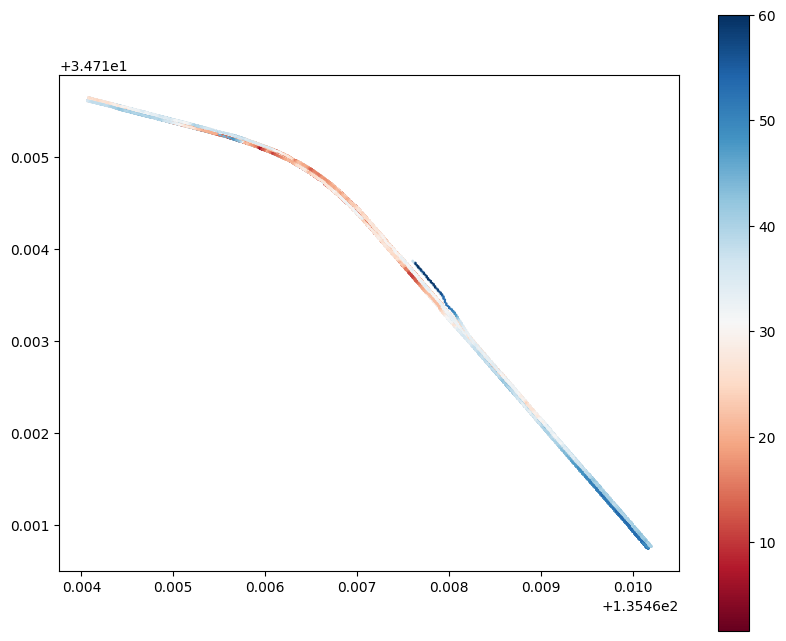

24/06/25 23:20:51 WARN TransportChannelHandler: Exception in connection from /10.138.143.225:59786
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpti

In [32]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(pdf, geometry="geometry")

gdf.plot(
    figsize=(10, 8),
    markersize=0.5,
    column="velocity",
    legend=True,
    cmap="RdBu"
)

In [15]:
import os

shapefile_loc = f"{os.getcwd()}/roadshapefile"

In [5]:
from sedona.core.formatMapper.shapefileParser import ShapefileReader

spatial_rdd = ShapefileReader.readToGeometryRDD(sc, shapefile_loc)

spatial_df = Adapter.toDf(spatial_rdd, spark)
spatial_df.createOrReplaceTempView("jpnroad")

In [12]:
spatial_df.show()

+--------------------+------+---+---+---+---+---+---+---+---+
|            geometry|f_code|acc|exs|rst|med|rtt|RSU|loc|soc|
+--------------------+------+---+---+---+---+---+---+---+---+
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 14|  1|  8|JPN|
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 14|  1|  8|JPN|
|LINESTRING (141.6...| AP030|  1| 28|  1|  0| 14|  1|  8|JPN|
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 14|  1|  8|JPN|
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.6...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.8...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.8...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.7...| AP030|  1| 28|  1|  0| 14|  1|  8|JPN|
|LINESTRING (142.1...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (148.4...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTRING (141.6...| AP030|  1| 28|  1|  0| 15|  1|  8|JPN|
|LINESTR

In [5]:
sc.stop()